In [3]:
import time
import numpy as np
import h5py
import hdf5plugin
import pandas as pd
import matplotlib as mpl
import matplotlib.colors as cm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from unyt import yr, Myr, kpc, arcsec, nJy, Mpc, Msun, erg, s, Hz, kelvin
from astropy.cosmology import Planck18 as cosmo
from scipy import signal

from synthesizer.emission_models.attenuation import PowerLaw
from synthesizer.filters import UVJ
from synthesizer.grid import Grid
from synthesizer.load_data.load_camels import load_CAMELS_IllustrisTNG
from synthesizer.sed import Sed
from synthesizer.parametric import SFH, ZDist
from synthesizer.particle.stars import sample_sfhz
from synthesizer.parametric import Stars as ParametricStars
from synthesizer.particle.particles import CoordinateGenerator
from synthesizer.filters import Filter, FilterCollection
from synthesizer.sed import combine_list_of_seds
from synthesizer.kernel_functions import Kernel
from synthesizer.conversions import lnu_to_absolute_mag
from synthesizer.emission_models.attenuation import PowerLaw
from synthesizer.emission_models.dust.emission import Blackbody, Greybody
from synthesizer.emission_models import (
    EmissionModel,
    AttenuatedEmission,
    BimodalPacmanEmission,
    DustEmission,
    EmissionModel,
    UnifiedAGN,
    CharlotFall2000,
    IncidentEmission,
    NebularEmission,
    ReprocessedEmission,
    StellarEmissionModel,
)
from synthesizer.conversions import lnu_to_absolute_mag, fnu_to_apparent_mag, fnu_to_lnu

In [4]:
# get grid for all galaxies
# gives grid of metalicity and age which is used to map on our camels galaxies
grid_name = "bc03_chabrier03-0.1,100.hdf5"
#grid_name = "bc03-2016-Miles_chabrier-0.1,100.hdf5" # try old grid, LF looks weird?!
grid_dir = "/home/jovyan/"
grid = Grid(grid_name, grid_dir=grid_dir, read_lines=False)

In [5]:
# get gals
CV_X = 'CV_0'
dir_ = '/home/jovyan/Data/Sims/IllustrisTNG/CV/' + CV_X
gals_074 = load_CAMELS_IllustrisTNG(
    dir_,
    snap_name='snapshot_074.hdf5', 
    group_name='groups_074.hdf5',
)



/srv/conda/envs/notebook/lib/python3.9/site-packages/unyt/array.py:1949: RuntimeWarning: invalid value encountered in divide
  out_arr = func(


In [6]:

print('Number of Galaxies in snap_074', len(gals_074))

cat_074 = dir_+'/groups_074.hdf5'
# open file
f = h5py.File(cat_074, 'r')

# read different attributes of the header
boxSize_074 = f['Header'].attrs[u'BoxSize']/1e3 #Mpc/h
redshift_074 = f['Header'].attrs[u'Redshift']
print('BoxSize: ', boxSize_074)
print('redshift: ', redshift_074)

Number of Galaxies in snap_074 18554
BoxSize:  25.0
redshift:  0.46525063335034633


In [7]:
# Filter galaxies to only include those with 100 or more star particles
## NEED TO ADD FILTER TO GET RID OF ANY GALAXIES WITH LESS THAN 100 star Particles!! This is the resolution limit!!
# Chris: when you load your galaxies in could you do a filter for those with at least 100 star particles? that's the resolution limit
gals_074 = [gal for gal in gals_074 if len(gal.stars.ages) >= 100]  # this shouldnt be here?! donesnt make sense
# Filter galaxies to only include those with 100 or more star particles
gals_074 = [gal for gal in gals_074 if gal.stars.nstars >= 100]
print(len(gals_074))
gals_074 = [gal for gal in gals_074 if gal.gas.nparticles >= 100]


370


In [8]:
incident = IncidentEmission(grid)
little_h =  0.6711

spec_list = []
# Lets work with z=0 so gals_025
for i in gals_074:
    gal = i
    # get_spectra_incident An Sed object containing the stellar spectra
    spec = gal.stars.get_spectra(incident)
    spec.get_fnu0()
    spec_list.append(spec)


In [9]:
# combine
seds = combine_list_of_seds(spec_list)
seds

In [10]:
seds.lnu  # get luminosity
# A typical value for the spectral luminosity density of a galaxy is around 28 erg/(Hz*s)

unyt_array([[2.38023700e+23, 2.91668649e+23, 3.38290830e+23, ...,
        1.13760191e+27, 8.34468117e+26, 6.37770369e+26],
       [4.54138101e+22, 5.85683078e+22, 7.05140769e+22, ...,
        5.75235747e+26, 4.22200694e+26, 3.22841638e+26],
       [1.76852202e+24, 2.06903766e+24, 2.25698407e+24, ...,
        1.62665166e+26, 1.19257948e+26, 9.11146175e+25],
       ...,
       [6.42393019e+21, 7.42143255e+21, 8.16826576e+21, ...,
        1.27496933e+25, 9.33793434e+24, 7.12778199e+24],
       [1.07748494e+22, 1.20065210e+22, 1.28673656e+22, ...,
        9.40436733e+24, 6.89219772e+24, 5.26396373e+24],
       [1.07936779e+22, 1.18686104e+22, 1.26182353e+22, ...,
        6.77711873e+24, 4.96291724e+24, 3.78778832e+24]], 'erg/(Hz*s)')

In [11]:
# Need to use the grid lam, dont need to define wavelengths here: see codes here: http://svo2.cab.inta-csic.es/theory/fps/index.php?id=Swift/UVOT.UVM2&&mode=browse&gname=Swift&gname2=UVOT#filter
# need to use transmission NOT area
# Get for XMM
fil_uvm2_XMM = Filter("XMM/OM.UVM2_filter", new_lam=grid.lam)

# now get for UVOT
fil_uvm2_UVOT = Filter("Swift/UVOT.UVM2_fil", new_lam=grid.lam) # changed from new_lam=lams_uvot to grid.lam and get 0 transmission, but warning sign is back

# what is a top hat filter?
filt1 = Filter("top_hat/filter.1", lam_min=1400, lam_max=1600, new_lam=grid.lam)

# 0 = TopHat, 1 = XMM, 2= Swift
filt_lst = [filt1, fil_uvm2_XMM, fil_uvm2_UVOT]

# get filters in combined array to apply to all galaxies
combined_filters = FilterCollection(
    filters=filt_lst, new_lam=grid.lam
)


In [12]:
combined_filters.filters

{'top_hat/filter.1': <synthesizer.filters.Filter at 0x7fd6e5668d90>,
 'XMM/OM.UVM2_filter': <synthesizer.filters.Filter at 0x7fd6e0f9a9d0>,
 'Swift/UVOT.UVM2_fil': <synthesizer.filters.Filter at 0x7fd6e5668b80>}

In [13]:
seds.get_photo_lnu(combined_filters, verbose=True) 
print(seds.get_photo_lnu(combined_filters, verbose=True))

--------------------------------------------------------------
|                  PHOTOMETRY (LUMINOSITY)                   |
|--------------------------------------|---------------------|
|  top_hat/filter.1 (λ = 1.50e+03 Å)   | 7.61e+30 erg/(Hz*s) |
|--------------------------------------|---------------------|
| XMM/OM.UVM2_filter (λ = 2.28e+03 Å)  | 7.53e+30 erg/(Hz*s) |
|--------------------------------------|---------------------|
| Swift/UVOT.UVM2_fil (λ = 2.25e+03 Å) | 7.56e+30 erg/(Hz*s) |
--------------------------------------------------------------



In [28]:
seds.photo_lnu

In [30]:
phot = seds.get_photo_lnu(combined_filters, verbose=True) 
print(phot)
# phot_mags = [lnu_to_absolute_mag(spec.photo_lnu[f] for f in combined_filters]

--------------------------------------------------------------
|                  PHOTOMETRY (LUMINOSITY)                   |
|--------------------------------------|---------------------|
|  top_hat/filter.1 (λ = 1.50e+03 Å)   | 7.61e+30 erg/(Hz*s) |
|--------------------------------------|---------------------|
| XMM/OM.UVM2_filter (λ = 2.28e+03 Å)  | 7.53e+30 erg/(Hz*s) |
|--------------------------------------|---------------------|
| Swift/UVOT.UVM2_fil (λ = 2.25e+03 Å) | 7.56e+30 erg/(Hz*s) |
--------------------------------------------------------------



In [33]:
abs_mags = [lnu_to_absolute_mag(phot[f]) for f in combined_filters.filters]
print(abs_mags)


[array([-19.20118218, -15.05566367, -21.51535124, -19.19294232,
       -17.95210487, -15.7327713 , -19.30572486, -16.91205658,
       -17.2885422 , -18.69786577, -19.5983846 , -17.74700443,
       -19.31723995, -19.25492237, -17.25156681, -17.73193074,
       -14.96828054, -18.95983803, -21.32392969, -19.93349455,
       -20.07324817, -15.91143955, -10.22060649, -19.08332995,
       -14.76495619, -14.31267689, -20.5253594 , -19.80989132,
       -21.38858322, -20.45962014, -18.98123823, -16.85935418,
       -18.74159421, -14.74521503, -17.21317657, -18.55379822,
       -17.20368303, -15.26655112, -19.46787172, -14.06112445,
       -19.95398678, -19.51384437, -18.81380798, -10.84217999,
       -21.72476072, -11.80527925, -19.76146324, -16.43842974,
       -17.96346312, -20.44987986, -19.20040164, -19.5304791 ,
       -10.95279695, -16.45113158, -17.34070006, -16.00325205,
       -15.7577353 , -10.79577073, -14.92915107, -19.52979115,
       -14.06081812, -13.2222556 , -18.43348265, -18.5

In [34]:
abs_mag_th = abs_mags[0]
abs_mag_th

array([-19.20118218, -15.05566367, -21.51535124, -19.19294232,
       -17.95210487, -15.7327713 , -19.30572486, -16.91205658,
       -17.2885422 , -18.69786577, -19.5983846 , -17.74700443,
       -19.31723995, -19.25492237, -17.25156681, -17.73193074,
       -14.96828054, -18.95983803, -21.32392969, -19.93349455,
       -20.07324817, -15.91143955, -10.22060649, -19.08332995,
       -14.76495619, -14.31267689, -20.5253594 , -19.80989132,
       -21.38858322, -20.45962014, -18.98123823, -16.85935418,
       -18.74159421, -14.74521503, -17.21317657, -18.55379822,
       -17.20368303, -15.26655112, -19.46787172, -14.06112445,
       -19.95398678, -19.51384437, -18.81380798, -10.84217999,
       -21.72476072, -11.80527925, -19.76146324, -16.43842974,
       -17.96346312, -20.44987986, -19.20040164, -19.5304791 ,
       -10.95279695, -16.45113158, -17.34070006, -16.00325205,
       -15.7577353 , -10.79577073, -14.92915107, -19.52979115,
       -14.06081812, -13.2222556 , -18.43348265, -18.54

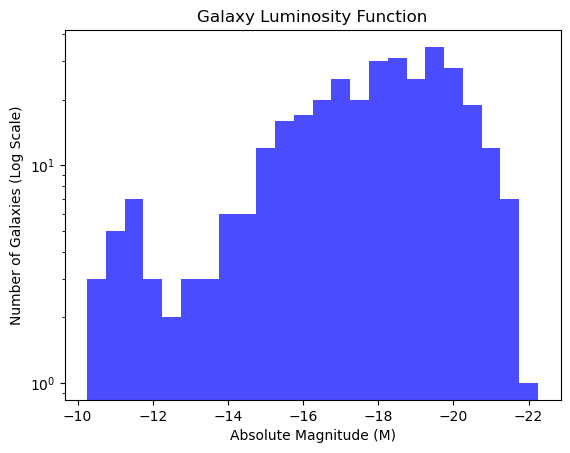

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Flatten your array to get all absolute magnitudes in a single array
abs_magnitudes = abs_mag_th.flatten()

# Define the bins for the histogram (you can adjust the bin size)
bins = np.arange(min(abs_magnitudes), max(abs_magnitudes), 0.5)

# Plot the histogram with a logarithmic y-axis
plt.hist(abs_magnitudes, bins=bins, color='blue', alpha=0.7)

# Log scale on the y-axis for the luminosity function
plt.yscale('log')

# Label the axes
plt.xlabel('Absolute Magnitude (M)')
plt.ylabel('Number of Galaxies (Log Scale)')

# Title and invert x-axis (brighter galaxies on the left)
plt.title('Galaxy Luminosity Function')
plt.gca().invert_xaxis()  # Magnitudes decrease from left to right
plt.show()


In [36]:
# check 
from astropy.cosmology import Planck18    # You can choose other cosmologies if needed

def apparent_magnitude_from_absolute(redshift, absolute_magnitude):
    # Get the luminosity distance for the given redshift
    # Distnaces are in parsecs
    d_L_pc = Planck18.luminosity_distance(redshift).to('pc').value
    
    # Calculate the apparent magnitude using the distance modulus formula
    apparent_mag = absolute_magnitude - 5 + (5 * np.log10(d_L_pc))
    
    return apparent_mag

ap_test = apparent_magnitude_from_absolute(redshift_074, abs_mag)
ap_test[1] # 1 is XMM-OM


24.924075945112342

Absolute magnitude is defined to be the apparent magnitude an object would have if it were located at a distance of 10 parsecs.
In astronomy, absolute magnitude (M) is a measure of the luminosity of a celestial object on an inverse logarithmic astronomical magnitude scale.

In [42]:
abs_mag_th = abs_mags[0]
abs_mag_th

array([-19.20118218, -15.05566367, -21.51535124, -19.19294232,
       -17.95210487, -15.7327713 , -19.30572486, -16.91205658,
       -17.2885422 , -18.69786577, -19.5983846 , -17.74700443,
       -19.31723995, -19.25492237, -17.25156681, -17.73193074,
       -14.96828054, -18.95983803, -21.32392969, -19.93349455,
       -20.07324817, -15.91143955, -10.22060649, -19.08332995,
       -14.76495619, -14.31267689, -20.5253594 , -19.80989132,
       -21.38858322, -20.45962014, -18.98123823, -16.85935418,
       -18.74159421, -14.74521503, -17.21317657, -18.55379822,
       -17.20368303, -15.26655112, -19.46787172, -14.06112445,
       -19.95398678, -19.51384437, -18.81380798, -10.84217999,
       -21.72476072, -11.80527925, -19.76146324, -16.43842974,
       -17.96346312, -20.44987986, -19.20040164, -19.5304791 ,
       -10.95279695, -16.45113158, -17.34070006, -16.00325205,
       -15.7577353 , -10.79577073, -14.92915107, -19.52979115,
       -14.06081812, -13.2222556 , -18.43348265, -18.54

In [43]:
abs_mag_xmm = abs_mags[1]
abs_mag_xmm


array([-19.76830914, -17.29299717, -21.45121654, -19.35631549,
       -18.13041163, -16.96422633, -19.23480621, -18.48274666,
       -17.58583179, -18.59231609, -19.48225277, -18.08296289,
       -19.35306317, -18.99946066, -17.31073081, -18.1971373 ,
       -16.71310277, -19.17924291, -21.30043647, -19.85934067,
       -19.96145022, -16.41621488, -13.37782033, -19.74679445,
       -16.78367439, -17.46833319, -20.61217372, -19.65505765,
       -21.32542602, -20.39819737, -19.25915051, -17.27574961,
       -18.98879219, -16.86043936, -17.63793966, -18.73289595,
       -17.48812186, -15.77286174, -19.70419674, -16.05502614,
       -20.04778279, -19.67040716, -18.84526958, -14.023377  ,
       -21.63256621, -14.4441852 , -19.72280777, -17.51533037,
       -18.56205601, -20.42370428, -19.33410461, -19.39276888,
       -13.9355701 , -16.73536456, -17.53412964, -16.51472314,
       -17.81399372, -13.77971573, -16.09837801, -19.55962442,
       -16.05837271, -15.83780451, -18.74162147, -18.74

In [44]:
abs_mag_swft = abs_mags[2]
abs_mag_swft

array([-19.74392377, -17.21587666, -21.45962445, -19.35565402,
       -18.12866485, -16.93991424, -19.24202004, -18.42735701,
       -17.57140065, -18.59952177, -19.49197606, -18.08126933,
       -19.35598732, -19.01453655, -17.31087204, -18.16894292,
       -16.64186618, -19.17766711, -21.30676377, -19.86662505,
       -19.96989964, -16.41112775, -13.30892425, -19.7281669 ,
       -16.71661329, -17.39530929, -20.61478914, -19.66644237,
       -21.33291174, -20.40593895, -19.25969147, -17.27212838,
       -18.96823412, -16.78123846, -17.63478677, -18.73176922,
       -17.48612258, -15.75519718, -19.6969049 , -15.98253208,
       -20.04974377, -19.6723489 , -18.84771629, -13.95622921,
       -21.64103695, -14.39110243, -19.72675537, -17.47107606,
       -18.5523163 , -20.43022281, -19.33584386, -19.40138822,
       -13.87675221, -16.7322559 , -17.53314083, -16.50593282,
       -17.74605051, -13.70661102, -16.05372768, -19.56395069,
       -15.99549808, -15.76172397, -18.74057585, -18.74

In [41]:
# next steps, get luminosity function for these magnitudes
# co-moving volume: BoxSize_025 and redshift:
little_h =  0.6711
Vphys = (boxSize_074/little_h )**3
Vcom = Vphys * ((1+redshift_074)**3)
print(Vcom)


162627.52885604533


In [45]:
# Alternative method for LF:
# try this method again, but using AB mag instead of mass, and suply your own bins (up to -17, say)
def calc_df(ab_mag, volume, massBinLimits):

# OG:        hist, dummy = np.histogram(np.log10(mstar), bins = massBinLimits)
        hist, dummy = np.histogram(ab_mag, bins = massBinLimits)
        hist = np.float64(hist)
        phi = (hist / volume) / (massBinLimits[1] - massBinLimits[0])

        phi_sigma = (np.sqrt(hist) / volume) /\
                    (massBinLimits[1] - massBinLimits[0]) # Poisson errors

        return phi, phi_sigma, hist

In [47]:
# Define the bin edges for AB magnitudes
# Here, let's define bins from -25 to -17 in steps of 0.5 magnitude
massBinLimits = np.arange(-22, -16, 0.5)

phi, phi_sigma, hist = calc_df(abs_mag_th, Vcom, massBinLimits)

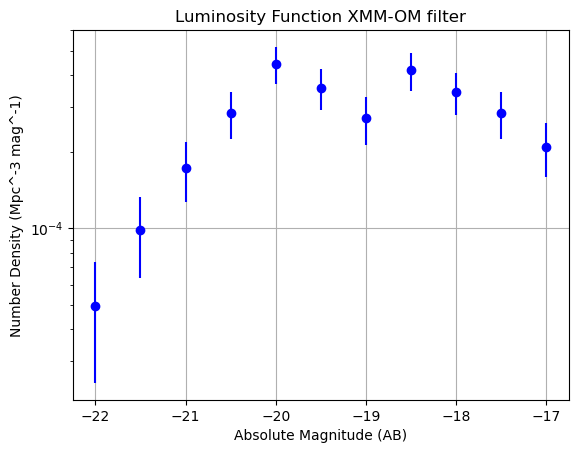

In [48]:
label_074 = 'z = ', redshift_074


# Plot the luminosity function
plt.errorbar(massBinLimits[:-1], phi, yerr=phi_sigma, fmt='o', color='blue')
plt.xlabel('Absolute Magnitude (AB)')
plt.ylabel('Number Density (Mpc^-3 mag^-1)')
plt.yscale('log')

plt.title('Luminosity Function XMM-OM filter')
plt.grid(True)
plt.show()

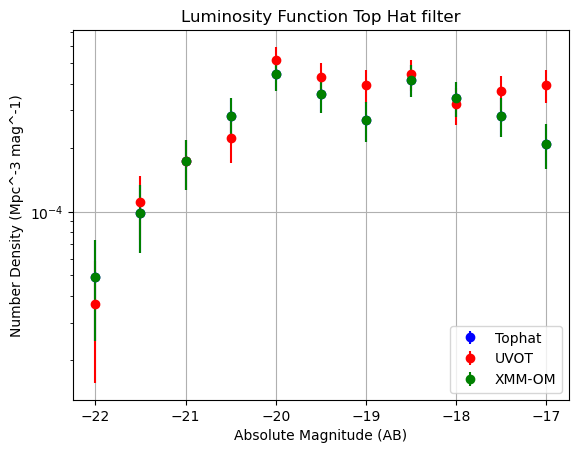

In [49]:
phi_th, phi_sigma_th, hist_th = calc_df(abs_mag_th, Vcom, massBinLimits)
phi_uv, phi_sigma_uv, hist_uv = calc_df(abs_mag_swft, Vcom, massBinLimits)

label_025 = 'z = ', redshift_074
label_swft = 'UVOT'
label_th = 'Tophat'
label_xmm = 'XMM-OM'

# Plot the luminosity function
plt.errorbar(massBinLimits[:-1], phi_th, yerr=phi_sigma_th, fmt='o', color='blue', label=label_th)
plt.errorbar(massBinLimits[:-1], phi_uv, yerr=phi_sigma_uv, fmt='o', color='red', label=label_swft)
plt.errorbar(massBinLimits[:-1], phi, yerr=phi_sigma, fmt='o', color='green', label=label_xmm)
plt.xlabel('Absolute Magnitude (AB)')
plt.ylabel('Number Density (Mpc^-3 mag^-1)')
plt.yscale('log')
plt.legend(loc='lower right')


plt.title('Luminosity Function Top Hat filter')
plt.grid(True)
plt.show()

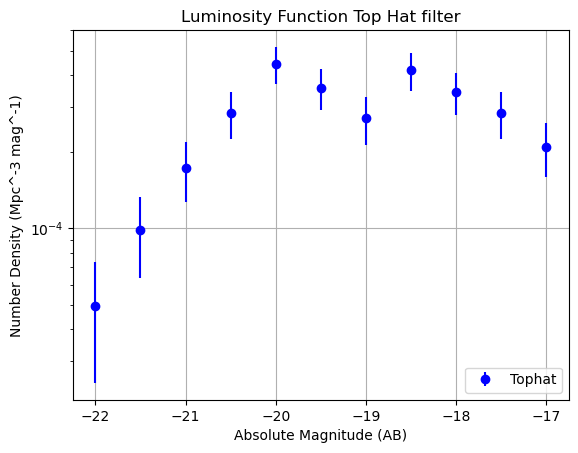

In [50]:

label_025 = 'z = ', redshift_074
label_th = 'Tophat'

# Plot the luminosity function
plt.errorbar(massBinLimits[:-1], phi_th, yerr=phi_sigma_th, fmt='o', color='blue', label=label_th)

plt.xlabel('Absolute Magnitude (AB)')
plt.ylabel('Number Density (Mpc^-3 mag^-1)')
plt.yscale('log')
plt.legend(loc='lower right')


plt.title('Luminosity Function Top Hat filter')
plt.grid(True)
plt.show()

# 